In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df = pd.read_spss('/media/data/personality/OOS Master Dataset Sept 2022/00_OOS_MASTER DATASET_2022_08_22.sav')
# plot histograms of all numeric variables and save to "figs/initial_histograms" directory
os.makedirs('figs/initial_histograms', exist_ok=True)
for col in df.select_dtypes(include='number'):
    try:
        df[col].hist()
        plt.title(col)
        plt.savefig(f'figs/initial_histograms/{col}.png')
        plt.close()
    except Exception as e:
        print(f'Error with {col}: {e}')
        continue

Error with year_born: supplied range of [-564395647826927.0, inf] is not finite
Error with age: supplied range of [-199000.0, inf] is not finite
Error with other_age: supplied range of [-818.0, inf] is not finite


In [10]:
df = pd.read_spss('/media/data/personality/OOS Master Dataset Sept 2022/00_OOS_MASTER DATASET_2022_08_22.sav')
# save only startdat column to csv
df['startdat'].to_csv('data/processed/initial/startdat.csv', index=False)
df_startdat = pd.read_csv('data/processed/initial/startdat.csv')
# get NA count for startdat column
print(df['startdat'].isna().sum())
# drop na values from startdat column
df_startdat = df_startdat.dropna(subset=['startdat'])

# convert startdat to datetime and plot histogram
df_startdat['startdat'] = pd.to_datetime(df_startdat['startdat'], errors='coerce')
df_startdat['startdat'].hist()
plt.title('startdat')
plt.savefig('figs/initial_histograms/startdat.png')
plt.close()


/tmp/ipykernel_3622328/1597830401.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_startdat = pd.read_csv('data/processed/initial/startdat.csv')


0


/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname GM identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/media/gisense/koichi/miniconda3/envs/personality/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [4]:
import os
os.makedirs('data/processed/initial', exist_ok=True)
df.describe().to_csv('data/processed/initial/initial_descriptive_stats.csv')

In [1]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Data loading functions
def load_oos_data(file_path):
    """Load and prepare OOS dataset"""
    df = pd.read_spss(file_path)
    
    # Convert zip codes to string and ensure proper formatting
    df['youth_zip'] = df['youth_zip'].astype(str).str.zfill(5)
    df['now_zip'] = df['now_zip'].astype(str).str.zfill(5)
    
    return df

def get_zipcode_shapes():
    """Load US ZIP Code shapefile"""
    zip_gdf = gpd.read_file('/media/data/personality/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp')
    zip_gdf['ZCTA5CE10'] = zip_gdf['ZCTA5CE10'].astype(str).str.zfill(5)
    return zip_gdf

def get_texas_zipcodes(gdf):
    """Filter GeoDataFrame for Texas ZIP codes"""
    texas_prefixes = ('75', '76', '77', '78', '79', '88')
    texas_mask = gdf['ZCTA5CE10'].str.startswith(texas_prefixes)
    return gdf[texas_mask].copy()

# Analysis functions
def calculate_zip_samples(df):
    """Calculate sample sizes for current and youth ZIP codes"""
    # Current ZIP codes
    current_counts = df['now_zip'].value_counts().reset_index()
    current_counts.columns = ['ZIP', 'current_samples']
    
    # Youth ZIP codes
    youth_counts = df['youth_zip'].value_counts().reset_index()
    youth_counts.columns = ['ZIP', 'youth_samples']
    
    # Merge both counts
    zip_counts = current_counts.merge(youth_counts, on='ZIP', how='outer').fillna(0)
    zip_counts['total_samples'] = zip_counts['current_samples'] + zip_counts['youth_samples']
    
    return zip_counts

def create_sample_maps(zip_gdf, zip_counts):
    """Create choropleth maps of sample sizes with separate files"""
    # Merge shapefile with sample counts
    map_data = zip_gdf.merge(zip_counts, left_on='ZCTA5CE10', right_on='ZIP', how='left')
    
    # Filter for mainland USA (excluding Alaska and Hawaii)
    mainland = map_data[~map_data['ZCTA5CE10'].str.startswith(('995', '996', '997', '998', '999', '968', '969'))]
    
    # Filter for Texas
    texas = get_texas_zipcodes(mainland)
    
    def plot_map(data, column, title, filename, state='US'):
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Plot all geometries with base color white
        data.plot(color='white', ax=ax)
        
        # Create mask for zero values
        zero_mask = data[column] == 0
        
        # Plot non-zero values with viridis colormap
        if (~zero_mask).any():
            data[~zero_mask].plot(
                column=column,
                ax=ax,
                legend=True,
                legend_kwds={'label': title},
                cmap='viridis'
            )
        
        state_label = 'Texas' if state == 'TX' else 'US'
        ax.set_title(f'{title} ({state_label})', fontsize=14)
        ax.axis('off')
        plt.tight_layout()
        
        suffix = '_texas' if state == 'TX' else ''
        fig.savefig(f'/media/gisense/koichi/personality/figs/{filename}{suffix}.png', 
                   dpi=300, bbox_inches='tight')
        plt.close(fig)
    
    # Create US maps
    plot_map(mainland, 'current_samples', 'Current Residents', 'current_residence_map')
    plot_map(mainland, 'youth_samples', 'Youth Residents', 'youth_residence_map')
    plot_map(mainland, 'total_samples', 'Total Samples', 'total_samples_map')
    
    # Create Texas maps
    plot_map(texas, 'current_samples', 'Current Residents', 'current_residence_map', 'TX')
    plot_map(texas, 'youth_samples', 'Youth Residents', 'youth_residence_map', 'TX')
    plot_map(texas, 'total_samples', 'Total Samples', 'total_samples_map', 'TX')
    
    return mainland


# Load data
df = load_oos_data('/media/data/personality/OOS Master Dataset Sept 2022/00_OOS_MASTER DATASET_2022_08_22.sav')
zip_gdf = get_zipcode_shapes()

# Calculate sample sizes
zip_counts = calculate_zip_samples(df)

# Create maps
map_data = create_sample_maps(zip_gdf, zip_counts)

# Print summary statistics
print("Sample Size Summary:")
print(f"Total ZIP codes with samples: {len(zip_counts)} out of {len(zip_gdf)}")
print("\nCurrent Residence Statistics:")
print(zip_counts['current_samples'].describe())
print("\nYouth Residence Statistics:")
print(zip_counts['youth_samples'].describe())

Sample Size Summary:
Total ZIP codes with samples: 879410 out of 33144

Current Residence Statistics:
count    8.794100e+05
mean     1.446954e+01
std      5.214529e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.833271e+06
Name: current_samples, dtype: float64

Youth Residence Statistics:
count    8.794100e+05
mean     1.446954e+01
std      5.293132e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.912185e+06
Name: youth_samples, dtype: float64


In [ ]:
# # in df, only keep zip codes that are in Austin, Dallas, Houston, and San Antonio
# df_now_tx = df[df['now_zip'].str.startswith(('752', '753',  # Dallas
#                                        '770', '771', '772',  # Houston 
#                                        '782',  # San Antonio
#                                        '787'))]  # Austin
# df_youth_tx = df[df['youth_zip'].str.startswith(('752', '753',  # Dallas
#                                        '770', '771', '772',  # Houston 
#                                        '782',  # San Antonio
#                                         '787'))]  # Austin

# show distribution of big five personality traits in each city
# Import the required functions from the big_five_analysis module
import importlib.util
spec = importlib.util.spec_from_file_location('big_five_analysis', 'code/big_five_analysis.py')
big_five = importlib.util.module_from_spec(spec)
spec.loader.exec_module(big_five)

# Run the Big Five analysis
big_five.analyze_big_five(df, df, map_data, map_type='us')


Calculating personality scores...
  Using all US ZIP codes...
  Processing current residence data...
  Processing youth residence data...

Generating US-wide personality trait maps...
  Creating US-wide Current residence map for extraversion...


78705      7961
78741      1804
78704      1683
77084      1388
75205      1206
           ... 
787080        1
787219        1
787978        1
770777        1
7700555       1
Name: now_zip, Length: 1223, dtype: int64
77084      1417
77095      1161
75211      1061
78250      1021
77024      1013
           ... 
7523BT        1
7822GG        1
7700 ak       1
7711 JZ       1
787837        1
Name: youth_zip, Length: 1301, dtype: int64
78251    1
78235    1
78234    1
78205    1
78210    1
        ..
75218    1
77076    1
77039    1
77081    1
78733    1
Name: ZCTA5CE10, Length: 252, dtype: int64
78705    7961
78741    1804
78704    1683
77084    1388
75205    1206
         ... 
78719      12
78742      12
78243      10
75390       5
77201       3
Name: now_zip, Length: 252, dtype: int64
average sample size for now zip codes: 404.6111111111111
77084    1417
77095    1161
75211    1061
78250    1021
77024    1013
         ... 
78742      17
78243      11
75251      10
77201       8
75390 

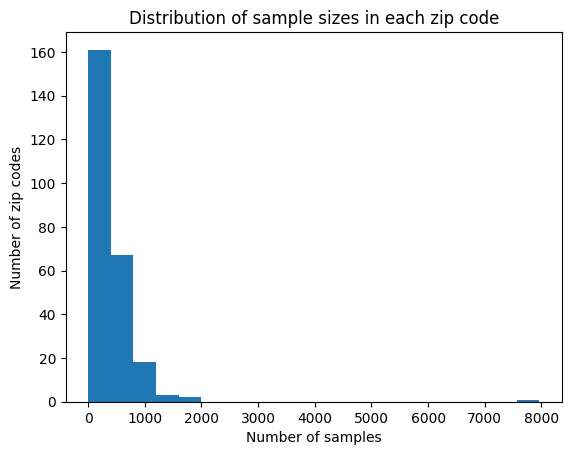

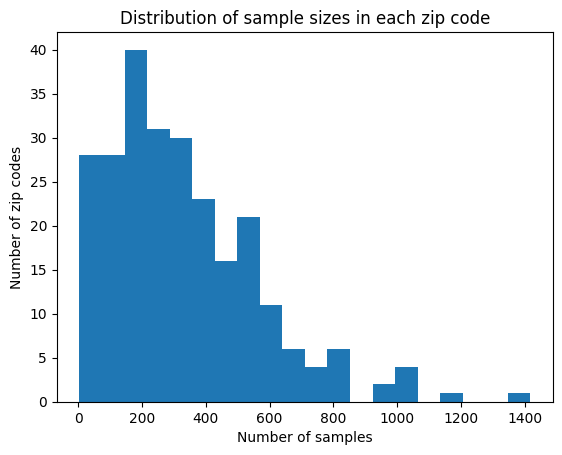

In [31]:
print(df_now_tx["now_zip"].value_counts())
print(df_youth_tx["youth_zip"].value_counts())
map_data_tx = map_data[map_data['ZCTA5CE10'].str.startswith(('752', '753',  # Dallas
                                        '770', '771', '772',  # Houston 
                                        '782',  # San Antonio
                                        '787'))]  # Austin
print(map_data_tx["ZCTA5CE10"].value_counts())

# join the dataframes
map_data_tx_now = map_data_tx.merge(df_now_tx, left_on='ZCTA5CE10', right_on='now_zip', how='left')
map_data_tx_youth = map_data_tx.merge(df_youth_tx, left_on='ZCTA5CE10', right_on='youth_zip', how='left')

# calculate the sample sizes for each zip code
count_now = map_data_tx_now["now_zip"].value_counts()
count_youth = map_data_tx_youth["youth_zip"].value_counts()
print(count_now)
print("average sample size for now zip codes: " + str(np.mean(count_now)))
print(count_youth)
print("average sample size for youth zip codes: " + str(np.mean(count_youth)))
# histogram of sample sizes in each zip code
plt.hist(count_now, bins=20)
plt.xlabel("Number of samples")
plt.ylabel("Number of zip codes")
plt.title("Distribution of sample sizes in each zip code")
plt.show()

plt.hist(count_youth, bins=20)
plt.xlabel("Number of samples")
plt.ylabel("Number of zip codes")
plt.title("Distribution of sample sizes in each zip code")
plt.show()



78705    7961
78741    1804
78704    1683
77084    1388
75205    1206
         ... 
78719      12
78742      12
78243      10
75390       5
77201       3
Name: now_zip, Length: 252, dtype: int64

In [10]:
df_now_tx.describe()

,record_id,user_id,survey_id,year_born,age,other_age,ext01,agr01r,cns01,neu01,...,obfi2_ext11r,obfi2_agr11,obfi2_cns11,obfi2_neu11,obfi2_opn11r,obfi2_ext12,obfi2_agr12,obfi2_cns12r,obfi2_neu12,obfi2_opn12
count,1.058040e+05,6.000000e+00,73207.000000,7.663300e+04,1.056590e+05,30978.000000,82869.000000,82869.000000,82869.000000,82869.000000,...,2353.000000,2354.000000,2353.000000,2352.000000,2352.000000,2352.000000,2353.000000,2352.000000,2351.000000,2352.000000
mean,6.730999e+08,2.171225e+15,2.167744,5.738693e+04,1.415668e+03,28.240429,3.484874,3.064946,4.023374,2.327807,...,3.422439,4.313509,4.056099,2.441327,3.467687,3.572704,3.401615,3.254252,2.921310,3.726616
std,1.054320e+09,2.261741e+15,0.649523,1.206919e+07,3.382228e+05,106.461705,1.152648,1.148496,0.907069,1.208998,...,1.274104,0.857117,1.071547,1.227070,1.179642,1.086158,1.170694,1.334673,1.335671,1.050655
min,1.035250e+06,4.752040e+14,2.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,6.045507e+06,5.646807e+14,2.000000,1.980000e+03,1.900000e+01,19.000000,3.000000,2.000000,4.000000,1.000000,...,2.000000,4.000000,3.000000,1.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000
50%,2.379645e+07,1.248592e+15,2.000000,1.990000e+03,2.300000e+01,23.000000,4.000000,3.000000,4.000000,2.000000,...,3.000000,5.000000,4.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000,4.000000
75%,2.014315e+09,2.951021e+15,2.000000,1.995000e+03,3.300000e+01,32.000000,4.000000,4.000000,5.000000,3.000000,...,5.000000,5.000000,5.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000
max,3.021485e+09,6.199758e+15,6.000000,3.244447e+09,1.000000e+08,18000.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
